In [1]:
import random
import re
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pyarrow
import seaborn as sns
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud

import infineac.constants as constants
import infineac.file_loader as file_loader
import infineac.helper as helper
import infineac.process_event as process_event
import infineac.process_text as process_text
import infineac.topic_extractor as topic_extractor
from infineac.pipeline import pipeline

%load_ext autoreload
%autoreload 2

PATH_DIR = "../data/transcripts/"
KEYWORDS = ["russia", "ukraine"]
BASE_YEAR = 2019
random.seed(111)

c:\Users\fgabelbe\AppData\Local\miniconda3\envs\infineac\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load NLP model

In [2]:
import spacy_stanza
nlp_stanza = spacy_stanza.load_pipeline("en", processors="tokenize, lemma")
nlp_stanza.add_pipe('sentencizer')

2023-11-13 22:16:45 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-11-13 22:16:46 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| lemma     | combined |

2023-11-13 22:16:46 WARNING: GPU requested, but is not available!
2023-11-13 22:16:46 INFO: Using device: cpu
2023-11-13 22:16:46 INFO: Loading: tokenize
2023-11-13 22:16:46 INFO: Loading: lemma
2023-11-13 22:16:46 INFO: Done loading processors!


## Load Files

Load all xml files from the given directory and return a list of corresponding events.

In [3]:
files = list(Path(PATH_DIR).rglob("*.xml"))
events = file_loader.load_files_from_xml(files)

Files: 100%|██████████| 189501/189501 [21:42<00:00, 145.46it/s]


Create a DataFrame with all companies and the corresponding year.

In [4]:
all_comp_df = pl.DataFrame(
    {
        "company_name": [event["company_name"] for event in events],
        "year": [event["date"].year for event in events if "date" in event.keys()],
    }
)
all_comp_df = all_comp_df.with_columns(year=pl.col("year").cast(pl.Int32))
all_comp_df = all_comp_df.filter(pl.col("year") >= BASE_YEAR)
all_comp_df = all_comp_df.unique()
helper.save_data(all_comp_df, "../output/cache/all_comp_df.lz4")

Check if all positions are valid.

In [5]:
process_event.test_positions(events)

## Filter data

Filter out all events that are not in the given time range and do not include the given keywords.

In [6]:
events_filt_all = process_event.filter_events(
    events, year=BASE_YEAR, keywords=KEYWORDS, modifier_words=[]
)
events_filt = process_event.filter_events(events, year=BASE_YEAR, keywords=KEYWORDS)
helper.save_data(events_filt, "../output/cache/events_filt.lz4")
len(events_filt)

Filtering events


Events: 100%|██████████| 189501/189501 [00:39<00:00, 4771.10it/s] 


Filtering events


Events: 100%|██████████| 189501/189501 [10:04<00:00, 313.50it/s] 


19909

List all **events**, that are filtered out due to modifier words preceding the keywords.

In [7]:
events_filtered_filter_words = []
ids_filtered_events = []
for i, event in enumerate(events_filt):
    ids_filtered_events.append(event['id'])
for event in events_filt_all:
    if event['id'] not in ids_filtered_events:
        events_filtered_filter_words.append(event)
print(len(events_filtered_filter_words))
process_event.extract_passages_from_events(events_filtered_filter_words, keywords=KEYWORDS, modifier_words=[], nlp_model=nlp_stanza)

16
Extracting passages from events


Events: 100%|██████████| 16/16 [00:00<00:00, 17.24it/s]


[[[[['However, in June, year-over-year volume growth in all countries, except Russia, driven by strong demand recovery and share gains in key countries, resulted in year-over-year net sales growth and positive EBIT in the month.']]],
  []],
 [[[['As for automotive glass, in addition to depreciation of euro, demand declines in areas except Russia.']]],
  []],
 [[[['Napo EU, which will be a private company, will have an exclusive license to crofelemer, our novel, proprietary drug for the indications of inflammatory diarrhea and the current approved indication of crofelemer, Mytesi in the United States HIV-related diarrhea, and this is the exclusive license in Europe, excluding Russia.']]],
  []],
 [[[['Napo EU is currently a wholly-owned European subsidiary of Napo Pharmaceuticals, Inc. in Italy with an exclusive European, excluding Russia, license to crofelemer technology from Jaguar.'],
    ["Napo Pharma's wholly-owned subsidiary, Napo EU, has executed a license agreement with Jaguar g

List some sentences, that are later filtered out due to modifier words preceding the keywords.

In [8]:
excluded_sentences_mod = process_event.excluded_sentences_by_mod_words(
    events_filt, keywords=KEYWORDS, nlp_model=nlp_stanza
)
excluded_sentences_mod_samples = random.sample(
    excluded_sentences_mod, min(25, len(excluded_sentences_mod))
)
with open("../output/samples/excluded_sentences_mod_samples.txt", "w") as f:
    for item in excluded_sentences_mod_samples:
        f.write("%s\n" % item.strip())
excluded_sentences_mod_samples

Documents: 100%|██████████| 286/286 [06:32<00:00,  1.37s/it]


['And once we see the services replaced, and confidence of the utilities, that they have got their enrichment lined up and excluding Russia, and they have got their conversion, we could actually see demand in the uranium side come in a far more concentrated fashion than would have been the case prior to February 24th.',
 'Americas and EMEIA, excluding Russia, were up double digits.',
 'Excluding Russia and in constant dollars, both businesses grew revenues at or about 20%.',
 'Credentials increased 8% year-over-year and are up 11%, excluding Russia.',
 'Finally, we continue our disciplined approach on new business, with our expected loss of 26 basis points, 7 basis points lower than that on our stock excluding Russia.',
 'Despite margin pressures, our excellent top line growth and diligent cost management enabled us to deliver currency-neutral adjusted diluted EPS growth of plus 11.9% to $5.34, excluding Russia and Ukraine.',
 '\r\n The combination with Swedish Match would enable us to

## Exploration

In [9]:
file = [event['file'] for event in events_filt]
id = [event['id'] for event in events_filt]
year_upload = [event['year_upload'] for event in events_filt]
company_name = [event['company_name'] for event in events_filt]
company_ticker = [event['company_ticker'] for event in events_filt]
ticker_new = [re.sub('\\..*', '', t) for t in company_ticker]
dates = [event['date'] for event in events_filt if "date" in event.keys()]
year = [d.year for d in dates]
numeric_values = mdates.date2num(dates)

russia_or_ukr_and_sanction = [process_text.get_russia_and_sanction(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
election = [process_text.get_elections(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
russia_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('russia') for event in events_filt]
ukraine_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('ukraine') for event in events_filt]
russia_or_ukraine_count = np.array(russia_count) + np.array(ukraine_count)
sanction_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('sanction') for event in events_filt]

Create a DataFrame with the following columns:

In [10]:
df_count_keywords = pd.DataFrame({'file': file,
                   'year_upload': year_upload,
                   'company_name': company_name,
                   'ticker':company_ticker,
                   'ticker_new': ticker_new,
                   'date': dates,
                   'year': year,
                   'dates_num' : numeric_values,
                   'russia': russia_or_ukr_and_sanction,
                   'russia_count': russia_count,
                   'ukraine_count': ukraine_count,
                   'russia_or_ukraine_count': russia_or_ukraine_count,
                   'sanction_count': sanction_count,
                   'election': election})

Aggregate the data by **company** and **year**.

In [11]:
df_count_keywords_comp = pl.DataFrame(
    df_count_keywords[
        ["year", "company_name", "russia_count", "ukraine_count", "sanction_count"]
    ]
)
df_count_keywords_comp = df_count_keywords_comp.groupby("company_name", "year").agg(
    pl.col("russia_count", "ukraine_count", "sanction_count").sum()
)
df_count_keywords_comp = df_count_keywords_comp.with_columns(
    year=pl.col("year").cast(pl.Int32)
)
df_count_keywords_comp

C:\Users\fgabelbe\AppData\Local\Temp\ipykernel_25732\3913359020.py:6: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  df_count_keywords_comp = df_count_keywords_comp.groupby("company_name", "year").agg(


company_name,year,russia_count,ukraine_count,sanction_count
str,i32,i64,i64,i64
"""BASF SE""",2019,1,0,0
"""L'Oreal SA""",2019,3,0,0
"""Symrise AG""",2019,1,0,0
"""Worley Ltd""",2019,1,0,1
"""Allegheny Tech…",2019,1,0,1
"""Grandvision NV…",2019,7,0,0
"""Gruppa LSR PAO…",2019,14,0,0
"""CapitaLand Ret…",2019,1,0,0
"""Mail.Ru Group …",2019,45,0,0


Count the number of occasions where the word "russia" (and "sanction") appears in the earnings call.

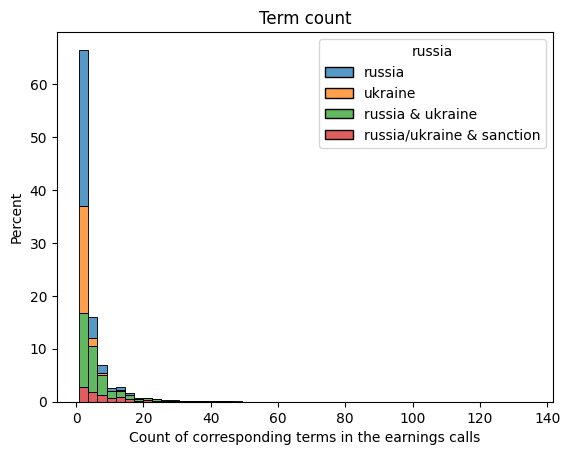

In [12]:
sns.histplot(df_count_keywords[(df_count_keywords['russia_count']>=1) | (df_count_keywords['ukraine_count']>=1)], x='russia_or_ukraine_count', hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
plt.xlabel('Count of corresponding terms in the earnings calls')
plt.ylabel('Percent')
plt.title('Term count')
plt.show()

Average mentions of "russia" per earnings call.

In [13]:
np.array(russia_count).mean()

2.8327389622783667

Average mentions of "russia" per earnings call if "russia" is mentioned at
least once.

In [14]:
np.array([el for el in russia_count if el > 0]).mean()

3.6488742236024843

Average mentions of "sanction" per earnings call.

In [15]:
np.array([el for el in sanction_count if el > 0]).mean()

2.442906574394464

Event distribution over time highlighting the different categories.

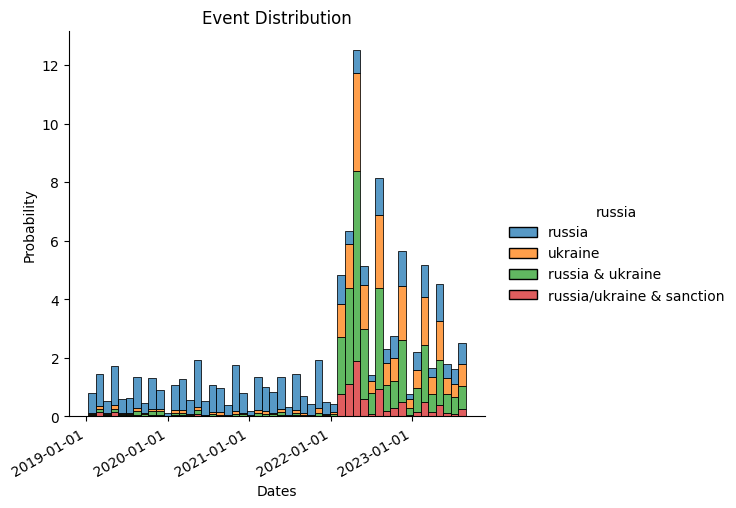

In [16]:
sns.displot(df_count_keywords, x="dates_num", hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
plt.xlabel('Dates')
plt.ylabel('Probability')
plt.title('Event Distribution')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

Event proportion over time highlighting the different categories.

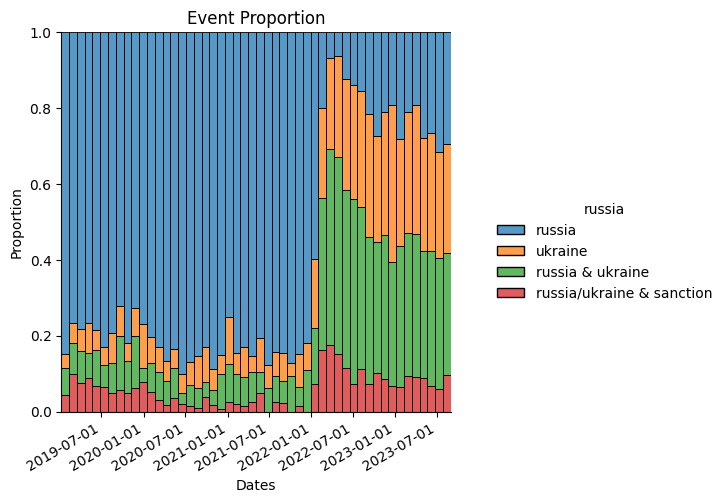

In [17]:
sns.displot(df_count_keywords, x="dates_num", hue="russia", bins=50, stat="proportion", common_norm=True, multiple="fill")
plt.xlabel('Dates')
plt.ylabel('Proportion')
plt.title('Event Proportion')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

## Preprocess and extract corpus

In [18]:
# events_filt = helper.load_data("..output/chache/events_filt.lz4")

By varying the window size and other parameters, we create different types of
corpora to obtain insights into the significance of these parameters. We will
compare the different results of the corpora to find the set of parameters,
which suits our purpose best.

The different corpora are:

1. Corpus with a window of [0,1] sentence and not joining adjacent sentences.
2. Corpus with a window of [0,1] sentence and joining adjacent sentences.
3. Corpus with a window of [0,3] sentences and joining adjacent sentences.
4. Corpus with a window of [0,5] sentences and joining adjacent sentences.
5. Corpus with a window that includes the whole paragraph from the keywords on.

In [19]:
corpus_window_0_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=False,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
corpus_window_0_df.head()

Extracting passages from events


Events:   0%|          | 1/19909 [00:00<33:38,  9.86it/s]

Events: 100%|██████████| 19909/19909 [22:24<00:00, 14.80it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 70658/70658 [11:58<00:00, 98.35it/s] 


event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str
0,0,0,0,0,"""And in Decembe…","""december board…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,0,"""Yes, about Rus…","""yes""",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,1,"""And it goes to…","""go germany cru…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,2,"""The Russian au…","""authority talk…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,3,"""So it is -- in…","""germany access…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""


In [20]:
corpus_window_0_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
len(corpus_window_0_join_df)

Extracting passages from events


Events: 100%|██████████| 19909/19909 [22:18<00:00, 14.87it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 62081/62081 [11:28<00:00, 90.22it/s] 


62081

In [21]:
corpus_window_3_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=[0,2],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
len(corpus_window_3_df)

Extracting passages from events


Events: 100%|██████████| 19909/19909 [22:16<00:00, 14.89it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 58090/58090 [14:11<00:00, 68.26it/s] 


58090

In [22]:
corpus_window_5_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=[0,4],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
len(corpus_window_5_df)

Extracting passages from events


Events: 100%|██████████| 19909/19909 [22:00<00:00, 15.08it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 57086/57086 [14:55<00:00, 63.75it/s] 


57086

In [23]:
corpus_window_whole_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=[0,-1],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
len(corpus_window_whole_df)

Extracting passages from events


Events: 100%|██████████| 19909/19909 [22:21<00:00, 14.84it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 57114/57114 [17:26<00:00, 54.58it/s] 


57114

Save and load data

In [24]:
helper.save_data(corpus_window_0_df, "../output/cache/corpus_window_0_df_no_answer.lz4")
helper.save_data(corpus_window_0_join_df, "../output/cache/corpus_window_0_join_df_no_answer.lz4")
helper.save_data(corpus_window_3_df, "../output/cache/corpus_window_3_join_df_no_answer.lz4")
helper.save_data(corpus_window_5_df, "../output/cache/corpus_window_5_join_df_no_answer.lz4")
helper.save_data(corpus_window_whole_df, "../output/cache/corpus_window_whole_join_df_no_answer.lz4")

In [25]:
# corpus_window_0_df = helper.load_data("../output/cache/corpus_window_0_df_no_answer.lz4")
# corpus_window_0_join_df = helper.load_data("../output/cache/corpus_window_0_join_df_no_answer.lz4")
# corpus_window_3_df = helper.load_data("../output/cache/corpus_window_3_join_df_no_answer.lz4")
# corpus_window_5_df = helper.load_data("../output/cache/corpus_window_5_join_df_no_answer.lz4")
# corpus_window_whole_df = helper.load_data("../output/cache/corpus_window_whole_join_df_no_answer.lz4")

## Extract Strategies

Add different strategies to the corpus:

In [26]:
corpus_window_0_df = process_text.get_strategies(dataframe=corpus_window_0_df)
corpus_window_0_join_df = process_text.get_strategies(dataframe=corpus_window_0_join_df)
corpus_window_3_df = process_text.get_strategies(dataframe=corpus_window_3_df)
corpus_window_5_df = process_text.get_strategies(dataframe=corpus_window_5_df)
corpus_window_whole_df = process_text.get_strategies(dataframe=corpus_window_whole_df)

Strategies: 100%|██████████| 3/3 [00:15<00:00,  5.09s/it]


Extract sample sentences for each strategy and save them.

In [27]:
strategy_samples = process_text.sample_strategies(corpus_window_0_df, 10)
with open("../output/samples/strategy_samples.txt", "w") as f:
    for item in strategy_samples:
        f.write("%s\n" % item)

Count exit strategies for different corpora

In [28]:
print("Count of exit strategies in smallest corpus:", sum(corpus_window_0_df['exit_strategy']))
print("Count of exit strategies in biggest corpus:", sum(corpus_window_whole_df['exit_strategy']))

Count of exit strategies in smallest corpus: 2865
Count of exit strategies in biggest corpus: 3522


## Analyse the corpora

### Smallest corpus: [0,1] window and no join

In [29]:
lengths = [len(doc) for doc in corpus_window_0_df['processed_text'].to_list()]
np.max(np.array(lengths))

1634

Text(0.5, 9.444444444444438, 'Document length')

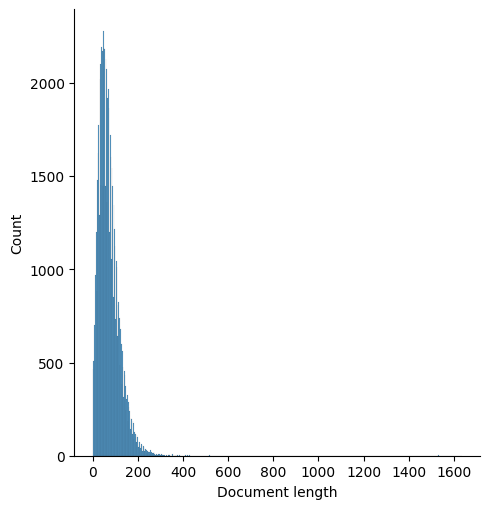

In [30]:
sns.displot(np.array(lengths))
plt.xlabel('Document length')

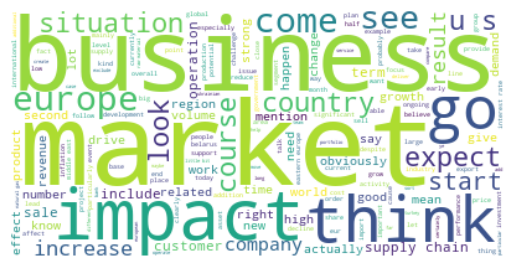

In [31]:
wc = WordCloud(background_color="white", max_words=1000)
wc.generate_from_text(" ".join(corpus_window_0_df['processed_text'].to_list()))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

### Biggest corpus: whole window and join adjacent sentences

In [32]:
lengths = [len(doc) for doc in corpus_window_whole_df['processed_text'].to_list()]
np.max(np.array(lengths))

6005

Text(0.5, 9.444444444444438, 'Document length')

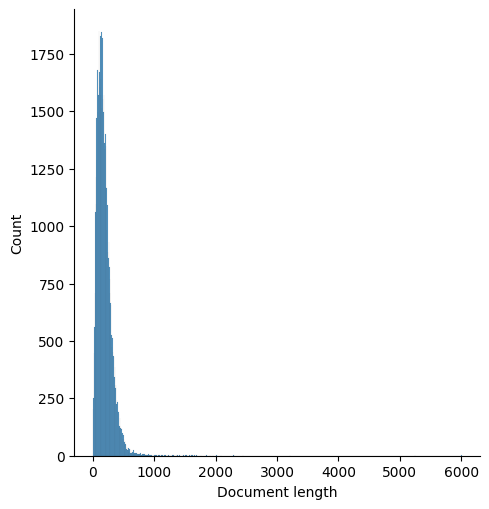

In [33]:
sns.displot(np.array(lengths))
plt.xlabel('Document length')

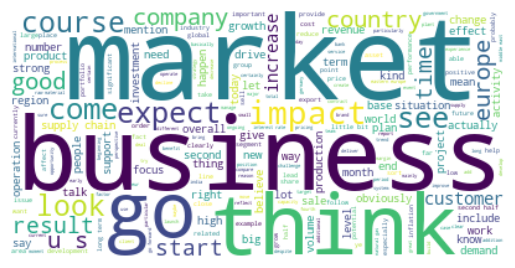

In [34]:
wc = WordCloud(background_color="white", max_words=1000)
wc.generate_from_text(" ".join(corpus_window_whole_df['processed_text'].to_list()))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Extract topics

In [35]:
# main_representation = KeyBERTInspired()
inspired_model = KeyBERTInspired()

# sentence model
sentence_model_light = SentenceTransformer("all-MiniLM-L6-v2")

# mmr model
mmr_model = MaximalMarginalRelevance(diversity=0.4)

# chain models
chain_model_1 = [inspired_model, mmr_model]

# Add all models together to be run in a single `fit`
representation_model = {
   "Main": inspired_model,
   "Chain: Inspired - MMR":  chain_model_1,
}

### 1 - Only target sentence
* Sentence window: 0
* No join

In [92]:
results_df_0, results_comp_0, categories_0, categories_count_0 = pipeline(preload_corpus=corpus_window_0_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 2154/2154 [02:19<00:00, 15.42it/s]
2023-11-14 07:45:21,190 - BERTopic - Transformed documents to Embeddings
2023-11-14 07:45:56,580 - BERTopic - Reduced dimensionality
2023-11-14 08:13:51,421 - BERTopic - Clustered reduced embeddings


In [93]:
categories_count_0

category,Count
str,i64
"""macro demand""",5643
"""finance""",5458
"""commodity""",5318
"""indirect geogr…",4252
"""misc""",3264
"""macro inflatio…",2429
"""supply chain""",2388
"""energy""",1463
"""humanitarian""",1380


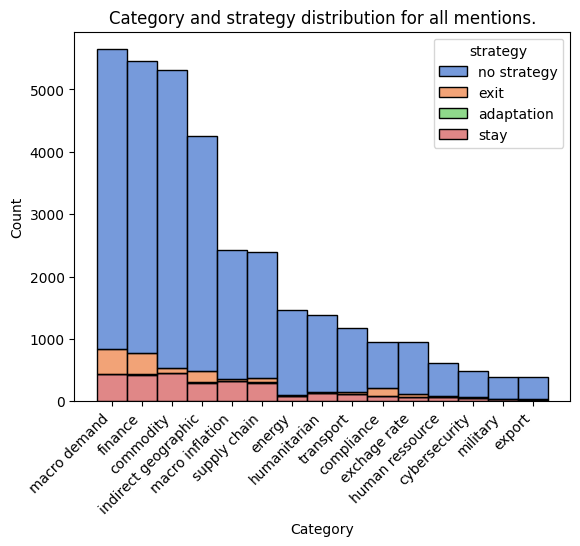

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",32365,1348,49,2970,27998
"""macro demand""",5643,394,6,437,4806
"""finance""",5458,335,11,427,4685
"""commodity""",5318,83,5,452,4778
"""indirect geogr…",4252,181,11,296,3764
"""misc""",3264,80,1,164,3019
"""macro inflatio…",2429,31,0,321,2077
"""supply chain""",2388,69,7,296,2016
"""empty""",1744,50,1,59,1634


In [38]:
topic_extractor.plot_category_distribution(results_df_0)

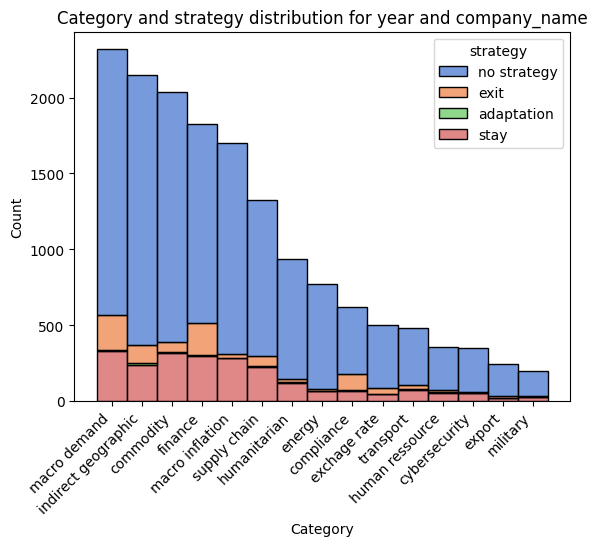

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",6964,673,44,1731,4516
"""macro demand""",2318,230,6,333,1749
"""indirect geogr…",2151,123,9,240,1779
"""commodity""",2034,65,5,318,1646
"""misc""",1905,73,1,149,1682
"""finance""",1823,210,8,297,1308
"""macro inflatio…",1704,28,0,285,1391
"""supply chain""",1323,60,7,228,1028
"""empty""",1125,46,1,54,1024


In [39]:
topic_extractor.plot_category_distribution(results_df_0, aggregate=['year', 'company_name'])

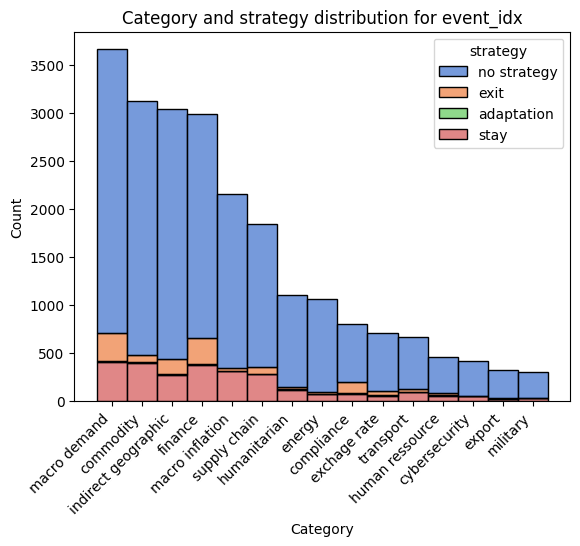

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",13427,968,49,2414,9996
"""macro demand""",3661,298,6,408,2949
"""commodity""",3118,79,5,401,2633
"""indirect geogr…",3042,152,10,277,2603
"""finance""",2987,273,11,375,2328
"""misc""",2579,79,1,161,2338
"""macro inflatio…",2158,30,0,313,1815
"""supply chain""",1842,67,7,280,1488
"""empty""",1427,48,1,56,1322


In [40]:
topic_extractor.plot_category_distribution(results_df_0, aggregate=['event_idx'])

In [94]:
results_comp_0 = results_comp_0.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_0 = all_comp_df.join(
    results_comp_0, on=["company_name", "year"], how="left"
)

In [85]:
helper.save_data(results_df_0, "../output/results/corpus_window_0_df_topic.lz4")
all_comp_results_0.write_excel("../output/results/topics_comp_0.xlsx")

In [42]:
for category in list(constants.CATEGORIES_TOPICS.keys()):
    lst = list(results_df_0.filter(pl.col("category") == category)["text"])
    sample_lst = random.sample(lst, min(10, len(lst)))
    with open("../output/samples/category_samples.txt", "a") as f:
        f.write("%s\n" % category)
        for item in sample_lst:
            f.write("%s\n" % item)
        f.write("\n\n")

### 2 - Only target sentence - join
* Sentence window: 0
* Join sentences

In [95]:
results_df_0_join, results_comp_0_join, categories_0_join, categories_count_0_join = pipeline(preload_corpus=corpus_window_0_join_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 1904/1904 [02:14<00:00, 14.18it/s]
2023-11-14 08:17:03,037 - BERTopic - Transformed documents to Embeddings
2023-11-14 08:17:34,338 - BERTopic - Reduced dimensionality
2023-11-14 08:31:20,528 - BERTopic - Clustered reduced embeddings


In [44]:
categories_count_0_join

category,Count
str,i64
"""commodity""",5920
"""macro demand""",4696
"""indirect geogr…",4496
"""finance""",4281
"""macro inflatio…",2174
"""misc""",1593
"""supply chain""",1561
"""exchage rate""",964
"""humanitarian""",948


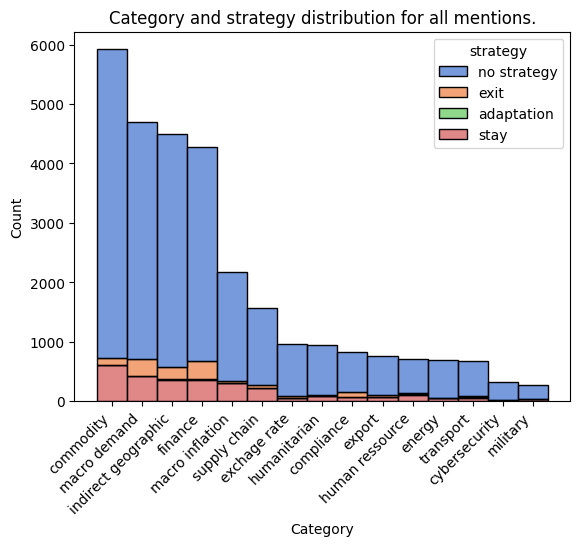

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",30018,1487,59,3011,25461
"""commodity""",5920,116,8,605,5191
"""macro demand""",4696,290,4,423,3979
"""indirect geogr…",4496,201,9,364,3922
"""finance""",4281,302,12,360,3607
"""macro inflatio…",2174,44,1,302,1827
"""misc""",1593,38,0,76,1479
"""supply chain""",1561,50,7,215,1289
"""empty""",1173,27,0,42,1104


In [45]:
topic_extractor.plot_category_distribution(results_df_0_join)

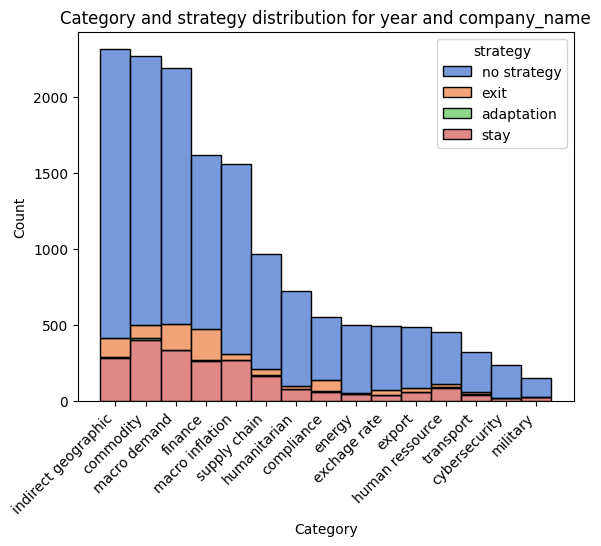

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",6909,728,49,1740,4392
"""indirect geogr…",2310,127,8,283,1892
"""commodity""",2266,89,8,404,1765
"""macro demand""",2189,169,4,335,1681
"""finance""",1615,199,9,265,1142
"""macro inflatio…",1557,39,1,273,1244
"""misc""",1116,36,0,72,1008
"""supply chain""",966,39,7,167,753
"""empty""",856,25,0,40,791


In [46]:
topic_extractor.plot_category_distribution(results_df_0_join, aggregate=['year', 'company_name'])

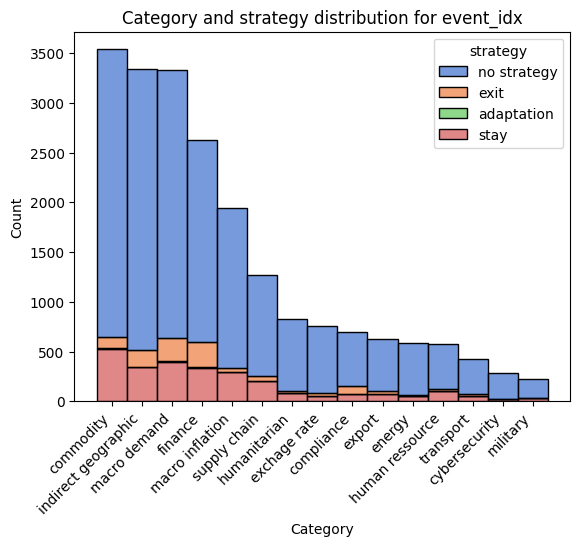

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",13322,1054,58,2440,9770
"""commodity""",3538,107,8,528,2895
"""indirect geogr…",3341,163,8,340,2830
"""macro demand""",3333,228,4,399,2702
"""finance""",2629,251,12,330,2036
"""macro inflatio…",1940,43,1,294,1602
"""misc""",1395,37,0,76,1282
"""supply chain""",1273,48,7,199,1019
"""empty""",1028,27,0,41,960


In [47]:
topic_extractor.plot_category_distribution(results_df_0_join, aggregate=['event_idx'])

In [96]:
results_comp_0_join = results_comp_0_join.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_0 = all_comp_df.join(
    results_comp_0_join, on=["company_name", "year"], how="left"
)

In [83]:
helper.save_data(results_df_0_join, "../output/results/corpus_window_0_join_df_topic.lz4")
all_comp_results_0.write_excel("../output/results/topics_comp_0_join.xlsx")

### 3 - 3 sentences - join
* Sentence window: 3
* Join sentences  

In [97]:
results_df_3, results_comp_3, categories_3, categories_count_3 = pipeline(preload_corpus=corpus_window_3_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 1803/1803 [03:01<00:00,  9.92it/s]
2023-11-14 08:35:15,484 - BERTopic - Transformed documents to Embeddings
2023-11-14 08:35:44,884 - BERTopic - Reduced dimensionality
2023-11-14 08:41:15,525 - BERTopic - Clustered reduced embeddings


In [50]:
categories_count_3

category,Count
str,i64
"""commodity""",4921
"""macro demand""",4241
"""finance""",3673
"""indirect geogr…",3068
"""humanitarian""",2497
"""macro inflatio…",1296
"""supply chain""",1072
"""misc""",804
"""transport""",640


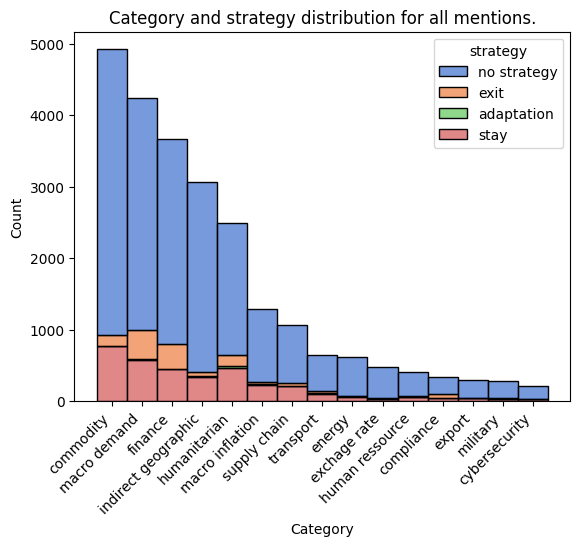

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",32801,1758,100,4950,25993
"""commodity""",4921,149,11,768,3993
"""macro demand""",4241,410,8,583,3240
"""finance""",3673,346,7,446,2874
"""indirect geogr…",3068,60,7,343,2658
"""humanitarian""",2497,163,17,471,1846
"""macro inflatio…",1296,26,4,234,1032
"""supply chain""",1072,37,5,214,816
"""misc""",804,41,2,102,659


In [51]:
topic_extractor.plot_category_distribution(results_df_3)

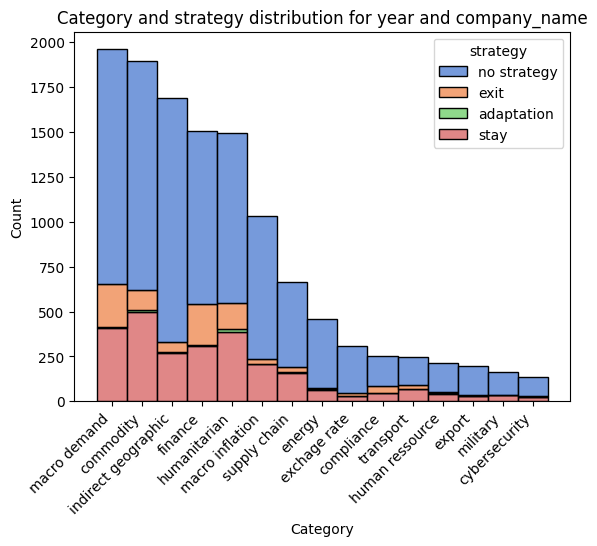

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",7458,860,89,2554,3955
"""macro demand""",1961,241,7,406,1307
"""commodity""",1896,110,11,500,1275
"""indirect geogr…",1690,55,7,267,1361
"""finance""",1504,230,4,307,963
"""humanitarian""",1494,145,16,388,945
"""macro inflatio…",1031,26,4,206,795
"""supply chain""",664,30,5,156,473
"""misc""",565,37,1,85,442


In [52]:
topic_extractor.plot_category_distribution(results_df_3, aggregate=['year', 'company_name'])

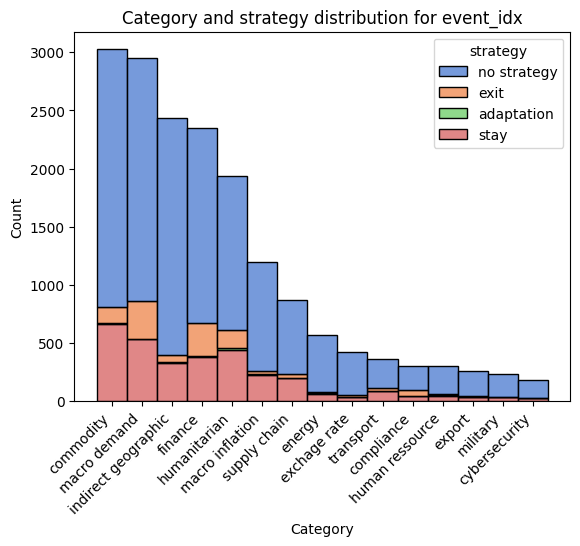

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",14614,1248,97,3802,9467
"""commodity""",3025,135,11,663,2216
"""macro demand""",2954,321,7,531,2095
"""indirect geogr…",2432,59,7,330,2036
"""finance""",2347,281,7,381,1678
"""humanitarian""",1934,156,17,437,1324
"""macro inflatio…",1199,26,4,227,942
"""supply chain""",871,32,5,199,635
"""misc""",706,41,2,100,563


In [53]:
topic_extractor.plot_category_distribution(results_df_3, aggregate=['event_idx'])

In [98]:
results_comp_3 = results_comp_3.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_3 = all_comp_df.join(
    results_comp_3, on=["company_name", "year"], how="left"
)

In [82]:
helper.save_data(results_df_3, "../output/results/corpus_window_3_df_topic.lz4")
all_comp_results_3.write_excel("../output/results/topics_comp_3.xlsx")

### 4. 5 sentences - join
* Sentence window: 5
* Join sentences

In [99]:
results_df_5, results_comp_5, categories_5, categories_count_5 = pipeline(preload_corpus=corpus_window_5_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 1772/1772 [03:12<00:00,  9.21it/s]
2023-11-14 08:45:21,514 - BERTopic - Transformed documents to Embeddings
2023-11-14 08:45:50,834 - BERTopic - Reduced dimensionality
2023-11-14 08:51:48,841 - BERTopic - Clustered reduced embeddings


In [56]:
categories_count_5

category,Count
str,i64
"""commodity""",4668
"""finance""",3824
"""indirect geogr…",3180
"""macro demand""",3054
"""humanitarian""",2393
"""macro inflatio…",2106
"""supply chain""",1575
"""misc""",748
"""transport""",716


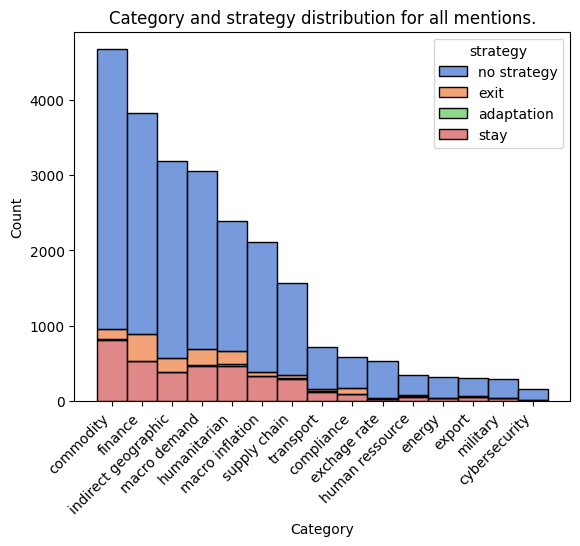

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",31865,1875,105,5230,24655
"""commodity""",4668,132,14,816,3706
"""finance""",3824,351,9,528,2936
"""indirect geogr…",3180,180,7,383,2610
"""macro demand""",3054,221,7,471,2355
"""humanitarian""",2393,179,22,472,1720
"""macro inflatio…",2106,45,4,333,1724
"""supply chain""",1575,43,8,297,1227
"""misc""",748,26,0,101,621


In [57]:
topic_extractor.plot_category_distribution(results_df_5)

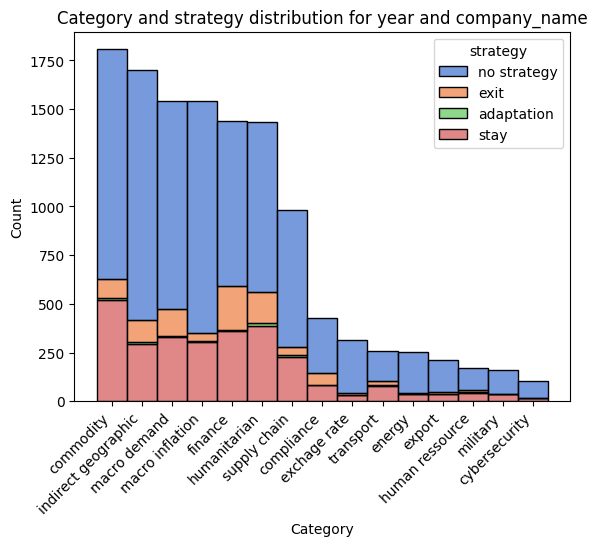

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",7416,918,99,2690,3709
"""commodity""",1807,98,12,519,1178
"""indirect geogr…",1703,113,7,295,1288
"""macro demand""",1543,140,5,331,1067
"""macro inflatio…",1542,44,4,305,1189
"""finance""",1438,223,6,361,848
"""humanitarian""",1433,159,20,384,870
"""supply chain""",982,43,8,227,704
"""misc""",503,23,0,78,402


In [58]:
topic_extractor.plot_category_distribution(results_df_5, aggregate=['year', 'company_name'])

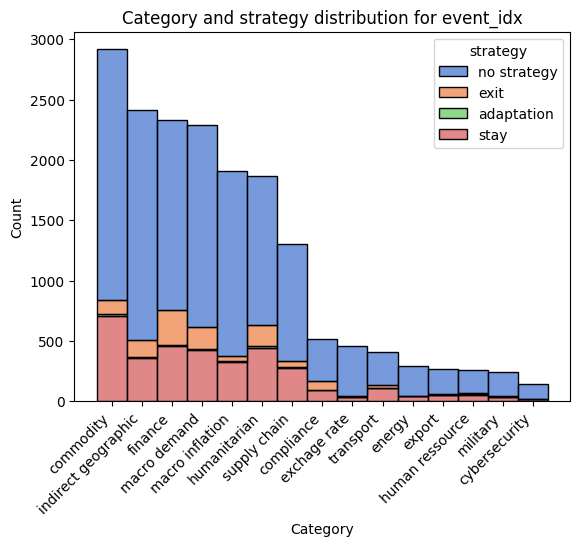

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",14475,1317,104,4003,9051
"""commodity""",2917,119,14,709,2075
"""indirect geogr…",2416,143,7,360,1906
"""finance""",2334,287,9,457,1581
"""macro demand""",2293,184,7,428,1674
"""macro inflatio…",1909,45,4,326,1534
"""humanitarian""",1864,174,21,438,1231
"""supply chain""",1306,43,8,279,976
"""misc""",643,26,0,96,521


In [59]:
topic_extractor.plot_category_distribution(results_df_5, aggregate=['event_idx'])

In [100]:
results_comp_5 = results_comp_5.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_5 = all_comp_df.join(
    results_comp_5, on=["company_name", "year"], how="left"
)

In [81]:
helper.save_data(results_df_5, "../output/results/corpus_window_5_df_topic.lz4")
all_comp_results_5.write_excel("../output/results/topics_comp_5.xlsx")

### 5. Whole paragraph - join
* Sentence window: whole paragraph
* Join sentences

In [61]:
results_df_whole, results_comp_whole, categories_whole, categories_count_whole = pipeline(preload_corpus=corpus_window_whole_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 1778/1778 [04:04<00:00,  7.27it/s]
2023-11-14 03:12:21,323 - BERTopic - Transformed documents to Embeddings
2023-11-14 03:12:49,852 - BERTopic - Reduced dimensionality
2023-11-14 03:16:45,393 - BERTopic - Clustered reduced embeddings


In [62]:
categories_count_whole

category,Count
str,i64
"""macro demand""",3986
"""commodity""",3747
"""macro inflatio…",3115
"""humanitarian""",2809
"""finance""",2800
"""indirect geogr…",2409
"""supply chain""",1213
"""exchage rate""",933
"""export""",531


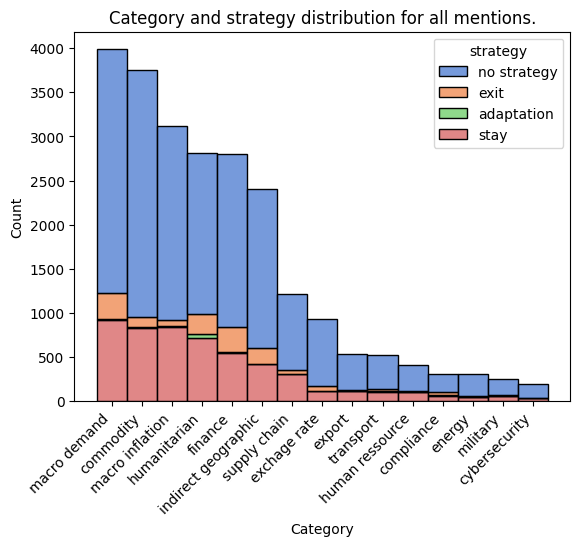

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",32903,2126,150,7008,23619
"""macro demand""",3986,300,9,920,2757
"""commodity""",3747,115,15,828,2789
"""macro inflatio…",3115,69,14,839,2193
"""humanitarian""",2809,225,46,715,1823
"""finance""",2800,279,10,547,1964
"""indirect geogr…",2409,178,7,419,1805
"""supply chain""",1213,44,4,309,856
"""exchage rate""",933,55,1,116,761


In [63]:
topic_extractor.plot_category_distribution(results_df_whole)

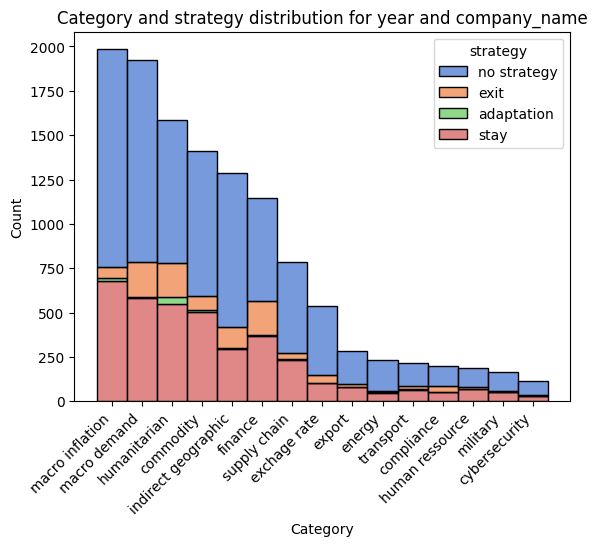

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",7351,1038,131,3237,2945
"""macro inflatio…",1984,66,14,679,1225
"""macro demand""",1921,193,9,581,1138
"""humanitarian""",1588,193,42,546,807
"""commodity""",1408,81,13,502,812
"""indirect geogr…",1287,115,6,297,869
"""finance""",1145,188,7,369,581
"""supply chain""",783,36,4,234,509
"""exchage rate""",539,46,1,101,391


In [64]:
topic_extractor.plot_category_distribution(results_df_whole, aggregate=['year', 'company_name'])

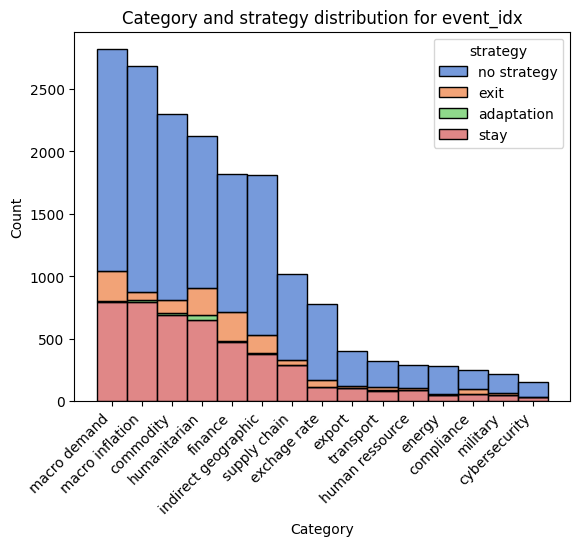

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",14503,1506,147,5055,7795
"""macro demand""",2818,238,9,797,1774
"""macro inflatio…",2681,69,14,793,1805
"""commodity""",2300,105,15,692,1488
"""humanitarian""",2121,215,45,648,1213
"""finance""",1817,236,10,472,1099
"""indirect geogr…",1815,146,7,377,1285
"""supply chain""",1019,41,4,289,685
"""exchage rate""",778,55,1,114,608


In [65]:
topic_extractor.plot_category_distribution(results_df_whole, aggregate=['event_idx'])

In [66]:
results_comp_whole = results_comp_whole.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_whole = all_comp_df.join(
    results_comp_whole, on=["company_name", "year"], how="left"
)

In [79]:
helper.save_data(results_df_whole, "../output/results/corpus_window_whole_df_topic.lz4")
all_comp_results_whole.write_excel("../output/results/topics_comp_whole.xlsx")

## Join results

In [87]:
helper.save_data(results_df_whole, "../output/results/corpus_window_whole_df_topic.lz4")
helper.save_data(results_df_0, "../output/results/corpus_window_0_df_topic.lz4")
helper.save_data(results_df_0_join, "../output/results/corpus_window_0_join_df_topic.lz4")
helper.save_data(results_df_3, "../output/results/corpus_window_3_df_topic.lz4")
helper.save_data(results_df_5, "../output/results/corpus_window_5_df_topic.lz4")

In [132]:
results_comp_compare = (
    results_comp_0.join(
        results_comp_0_join.select(["company_name", "year", "topic", "category"]),
        on=["company_name", "year"],
        how="left",
        suffix="_0_join",
    )
    .join(
        results_comp_3.select(["company_name", "year", "topic", "category"]),
        on=["company_name", "year"],
        how="left",
        suffix="_3",
    )
    .join(
        results_comp_5.select(["company_name", "year", "topic", "category"]),
        on=["company_name", "year"],
        how="left",
        suffix="_5",
    )
    .join(
        results_comp_whole.select(["company_name", "year", "topic", "category"]),
        on=["company_name", "year"],
        how="left",
        suffix="_whole",
    )
)
results_comp_compare = results_comp_compare.rename(
    {"topic": "topic_0", "category": "category_0"}
)
results_comp_compare

company_name,year,exit_strategy,stay_strategy,adaptation_strategy,topic_0,category_0,russia_count,ukraine_count,sanction_count,topic_0_join,category_0_join,topic_3,category_3,topic_5,category_5,topic_whole,category_whole
str,i32,u32,u32,u32,list[i64],list[str],i64,i64,i64,list[i64],list[str],list[i64],list[str],list[i64],list[str],list[i64],list[str]
"""01 Communique …",2022,0,0,0,[53],"[""standard"", ""cybersecurity""]",2,2,0,[51],"[""standard"", ""cybersecurity""]",[24],"[""standard"", ""cybersecurity""]","[2, 31]","[""cybersecurity"", ""standard"", ""supply chain""]",[20],"[""standard"", ""cybersecurity""]"
"""180 Degree Cap…",2022,0,1,0,"[29, 59, … 242]","[""macro inflation"", ""commodity"", … ""misc""]",7,5,0,"[3, 23]","[""macro inflation"", ""commodity"", ""standard""]","[8, 13, 36]","[""macro inflation"", ""commodity"", … ""macro demand""]","[4, 6, 28]","[""macro inflation"", ""commodity"", ""standard""]","[1, 6, 13]","[""macro inflation"", ""commodity"", … ""misc""]"
"""180 Degree Cap…",2023,0,0,0,[11],"[""macro inflation""]",1,1,0,[10],"[""macro inflation""]",[],"[""standard""]",[],"[""standard""]",[1],"[""macro inflation""]"
"""1847 Goedeker …",2022,0,0,0,[],"[""standard""]",0,1,0,[],"[""standard""]",[],"[""standard""]",[],"[""standard""]",[1],"[""macro inflation""]"
"""2020 Bulkers L…",2022,0,0,0,[562],"[""macro demand"", ""standard""]",2,1,0,[2],"[""commodity"", ""standard""]",[7],"[""commodity"", ""standard""]",[7],"[""commodity"", ""standard""]",[7],"[""macro demand"", ""standard""]"
"""3D Systems Cor…",2023,1,0,0,"[113, 525]","[""macro demand"", ""standard""]",2,2,0,[],"[""standard""]",[242],"[""macro demand"", ""standard""]",[232],"[""export"", ""standard""]",[203],"[""macro demand"", ""standard""]"
"""3D Systems Cor…",2022,9,2,0,"[-2, 0, … 573]","[""macro demand"", ""energy"", … ""humanitarian""]",21,7,0,"[4, 10, … 191]","[""macro demand"", ""standard"", … ""supply chain""]","[0, 12, … 352]","[""macro demand"", ""standard"", … ""humanitarian""]","[0, 2, … 160]","[""macro demand"", ""standard"", … ""humanitarian""]","[0, 1, … 193]","[""standard"", ""finance"", … ""humanitarian""]"
"""3M Co""",2023,26,1,0,"[-2, 50, … 463]","[""macro demand"", ""human ressource"", … ""supply chain""]",32,0,0,"[-2, 26, … 359]","[""macro demand"", ""human ressource"", … ""compliance""]","[11, 60, … 259]","[""macro demand"", ""human ressource"", … ""macro inflation""]","[53, 80, 264]","[""macro demand"", ""macro inflation"", ""standard""]","[5, 29, 265]","[""macro demand"", ""standard"", ""finance""]"
"""3M Co""",2022,6,2,0,"[-2, 2, … 482]","[""macro demand"", ""standard"", … ""supply chain""]",11,9,0,"[4, 10, … 359]","[""macro demand"", ""standard"", … ""supply chain""]","[0, 5, … 371]","[""macro demand"", ""standard"", … ""humanitarian""]","[0, 2, … 264]","[""macro demand"", ""standard"", … ""humanitarian""]","[0, 3, … 265]","[""macro demand"", ""standard"", … ""humanitarian""]"


In [193]:
results_comp_compare = results_comp_compare.with_columns(
    topic_intersection=pl.col("topic_0")
    .list.set_intersection("topic_0_join")
    .list.set_intersection("topic_3")
    .list.set_intersection("topic_5")
    .list.set_intersection("topic_whole"),
    topic_union=pl.col("topic_0")
    .list.set_union("topic_0_join")
    .list.set_union("topic_3")
    .list.set_union("topic_5")
    .list.set_union("topic_whole"),
    category_intersection=pl.col("category_0")
    .list.set_intersection("category_0_join")
    .list.set_intersection("category_3")
    .list.set_intersection("category_5")
    .list.set_intersection("category_whole"),
    category_union=pl.col("category_0")
    .list.set_union("category_0_join")
    .list.set_union("category_3")
    .list.set_union("category_5")
    .list.set_union("category_whole"),
)

results_comp_compare = results_comp_compare.with_columns(
    pl.when(pl.col("topic_union").list.len() == 0)
    .then(pl.lit(0))
    .otherwise(
        pl.col("topic_intersection").list.len() / pl.col("topic_union").list.len()
    )
    .alias("jaccard_topic_combined"),
    pl.when(pl.col("category_union").list.len() == 0)
    .then(pl.lit(0))
    .otherwise(
        pl.col("category_intersection").list.len() / pl.col("category_union").list.len()
    )
    .alias("jaccard_category_combined"),
)

topic_names = ["topic_0", "topic_0_join", "topic_3", "topic_5", "topic_whole"]
category_names = [
    "category_0",
    "category_0_join",
    "category_3",
    "category_5",
    "category_whole",
]
jaccard_similarity_pairwise_topics = helper.jaccard_similarity_pairwise(
    topic_names, results_comp_compare
)
jaccard_similarity_pairwise_categories = helper.jaccard_similarity_pairwise(
    category_names, results_comp_compare
)

results_comp_compare = results_comp_compare.with_columns(
    pl.Series(name="jaccard_topic_pairwise", values=jaccard_similarity_pairwise_topics)
)
results_comp_compare = results_comp_compare.with_columns(
    pl.Series(
        name="jaccard_category_pairwise", values=jaccard_similarity_pairwise_categories
    )
)

results_comp_compare = results_comp_compare.select(
    "company_name",
    "year",
    "russia_count",
    "ukraine_count",
    "sanction_count",
    "exit_strategy",
    "stay_strategy",
    "adaptation_strategy",
    "topic_0",
    "topic_0_join",
    "topic_3",
    "topic_5",
    "topic_whole",
    "topic_intersection",
    "topic_union",
    "category_0",
    "category_0_join",
    "category_3",
    "category_5",
    "category_whole",
    "category_intersection",
    "category_union",
    "jaccard_topic_pairwise",
    "jaccard_category_pairwise",
    "jaccard_topic_combined",
    "jaccard_category_combined",
)
results_comp_compare

company_name,year,russia_count,ukraine_count,sanction_count,exit_strategy,stay_strategy,adaptation_strategy,topic_0,topic_0_join,topic_3,topic_5,topic_whole,topic_intersection,topic_union,category_0,category_0_join,category_3,category_5,category_whole,category_intersection,category_union,jaccard_topic_pairwise,jaccard_category_pairwise,jaccard_topic_combined,jaccard_category_combined
str,i32,i64,i64,i64,u32,u32,u32,list[i64],list[i64],list[i64],list[i64],list[i64],list[i64],list[i64],list[str],list[str],list[str],list[str],list[str],list[str],list[str],f64,f64,f64,f64
"""01 Communique …",2022,2,2,0,0,0,0,[53],[51],[24],"[2, 31]",[20],[],"[53, 51, … 20]","[""standard"", ""cybersecurity""]","[""standard"", ""cybersecurity""]","[""standard"", ""cybersecurity""]","[""cybersecurity"", ""standard"", ""supply chain""]","[""standard"", ""cybersecurity""]","[""standard"", ""cybersecurity""]","[""standard"", ""cybersecurity"", ""supply chain""]",0.0,0.866667,0.0,0.666667
"""180 Degree Cap…",2022,7,5,0,0,1,0,"[29, 59, … 242]","[3, 23]","[8, 13, 36]","[4, 6, 28]","[1, 6, 13]",[],"[29, 59, … 1]","[""macro inflation"", ""commodity"", … ""misc""]","[""macro inflation"", ""commodity"", ""standard""]","[""macro inflation"", ""commodity"", … ""macro demand""]","[""macro inflation"", ""commodity"", ""standard""]","[""macro inflation"", ""commodity"", … ""misc""]","[""macro inflation"", ""commodity"", ""standard""]","[""macro inflation"", ""commodity"", … ""macro demand""]",0.04,0.77,0.0,0.6
"""180 Degree Cap…",2023,1,1,0,0,0,0,[11],[10],[],[],[1],[],"[11, 10, 1]","[""macro inflation""]","[""macro inflation""]","[""standard""]","[""standard""]","[""macro inflation""]",[],"[""macro inflation"", ""standard""]",0.0,0.4,0.0,0.0
"""1847 Goedeker …",2022,0,1,0,0,0,0,[],[],[],[],[1],[],[1],"[""standard""]","[""standard""]","[""standard""]","[""standard""]","[""macro inflation""]",[],"[""standard"", ""macro inflation""]",0.0,0.6,0.0,0.0
"""2020 Bulkers L…",2022,2,1,0,0,0,0,[562],[2],[7],[7],[7],[],"[562, 2, 7]","[""macro demand"", ""standard""]","[""commodity"", ""standard""]","[""commodity"", ""standard""]","[""commodity"", ""standard""]","[""macro demand"", ""standard""]","[""standard""]","[""macro demand"", ""standard"", ""commodity""]",0.3,0.6,0.0,0.333333
"""3D Systems Cor…",2023,2,2,0,1,0,0,"[113, 525]",[],[242],[232],[203],[],"[113, 525, … 203]","[""macro demand"", ""standard""]","[""standard""]","[""macro demand"", ""standard""]","[""export"", ""standard""]","[""macro demand"", ""standard""]","[""standard""]","[""macro demand"", ""standard"", ""export""]",0.0,0.6,0.0,0.333333
"""3D Systems Cor…",2022,21,7,0,9,2,0,"[-2, 0, … 573]","[4, 10, … 191]","[0, 12, … 352]","[0, 2, … 160]","[0, 1, … 193]",[],"[-2, 0, … 193]","[""macro demand"", ""energy"", … ""humanitarian""]","[""macro demand"", ""standard"", … ""supply chain""]","[""macro demand"", ""standard"", … ""humanitarian""]","[""macro demand"", ""standard"", … ""humanitarian""]","[""standard"", ""finance"", … ""humanitarian""]","[""standard"", ""finance"", ""macro inflation""]","[""macro demand"", ""energy"", … ""humanitarian""]",0.065276,0.683333,0.0,0.333333
"""3M Co""",2023,32,0,0,26,1,0,"[-2, 50, … 463]","[-2, 26, … 359]","[11, 60, … 259]","[53, 80, 264]","[5, 29, 265]",[],"[-2, 50, … 265]","[""macro demand"", ""human ressource"", … ""supply chain""]","[""macro demand"", ""human ressource"", … ""compliance""]","[""macro demand"", ""human ressource"", … ""macro inflation""]","[""macro demand"", ""macro inflation"", ""standard""]","[""macro demand"", ""standard"", ""finance""]","[""macro demand"", ""standard""]","[""macro demand"", ""human ressource"", … ""finance""]",0.007143,0.509286,0.0,0.25
"""3M Co""",2022,11,9,0,6,2,0,"[-2, 2, … 482]","[4, 10, … 359]","[0, 5, … 371]","[0, 2, … 264]","[0, 3, … 265]",[],"[-2, 2, … 265]","[""macro demand"", ""standard"", … ""supply chain""]","[""macro demand"", ""standard"", … ""supply chain""]","[""macro demand"", ""standard"", … ""humanitarian""]","[""macro

In [194]:
results_comp_compare.select(
    pl.mean("jaccard_topic_pairwise"),
    pl.mean("jaccard_category_pairwise"),
    pl.mean("jaccard_topic_combined"),
    pl.mean("jaccard_category_combined"),
)

jaccard_topic_pairwise,jaccard_category_pairwise,jaccard_topic_combined,jaccard_category_combined
f64,f64,f64,f64
0.037066,0.568232,0.002017,0.276082


In [195]:
helper.save_data(results_comp_compare, "../output/results/results_comp_compare.lz4")
results_comp_compare.write_excel("../output/results/results_comp_compare.xlsx")